In [1]:
#Import required libraries
import os
import argparse
import networkx as nx
import math        
import numpy as np
import helper
import astar
import tensorflow.compat.v1 as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import csv
from random import randint, random, seed, uniform
import time

# (restrict tensorflow memory growth)
tf.disable_v2_behavior()
os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

# neural network parameters
mb_size = 256
h_Q_dim = 512
h_P_dim = 512

c = 0
# learning rate
lr = 1e-4

# problem dimensions
dim = 2
dataElements = dim*3 + 100 # sample (2D), init(2D), goal(2D), occup_grid(100) 

z_dim = 2 # latent
X_dim = dim # samples
y_dim = dim # reconstruction of the original point
c_dim = dataElements - dim # dimension of conditioning variable

/home/ultrainstinct/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ultrainstinct/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ultrainstinct/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ultrainstinct/.local/lib/python3.5/site-packages/tensorflow/pyth

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# define networks
print("X_dim = ",X_dim)
print("c_dim = ",c_dim)
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=[None, X_dim])
c = tf.placeholder(tf.float32, shape=[None, c_dim])
    
# Q
inputs_Q = tf.concat(axis=1, values=[X,c])

dense_Q1 = tf.layers.dense(inputs=inputs_Q, units=h_Q_dim, activation=tf.nn.relu)
dropout_Q1 = tf.layers.dropout(inputs=dense_Q1, rate=0.5)
dense_Q2 = tf.layers.dense(inputs=dropout_Q1, units=h_Q_dim, activation=tf.nn.relu)

z_mu = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_mu
z_logvar = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_logvar

# P
eps = tf.random_normal(shape=tf.shape(z_mu))
z = z_mu + tf.exp(z_logvar / 2) * eps
inputs_P = tf.concat(axis=1, values=[z,c])

dense_P1 = tf.layers.dense(inputs=inputs_P, units=h_P_dim, activation=tf.nn.relu)
dropout_P1 = tf.layers.dropout(inputs=dense_P1, rate=0.5)
dense_P2 = tf.layers.dense(inputs=dropout_P1, units=h_P_dim, activation=tf.nn.relu)

y = tf.layers.dense(inputs=dense_P2, units=X_dim) # fix to also output y

w = [[1, 1]];
recon_loss = tf.losses.mean_squared_error(labels=X, predictions=y, weights=w)

kl_loss = 10**-4 * 2 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

cvae_loss = tf.reduce_mean(kl_loss + recon_loss)

train_step = tf.train.AdamOptimizer(lr).minimize(cvae_loss)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
it = 0;

X_dim =  2
c_dim =  104
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.dropout instead.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [3]:
saver = tf.train.Saver()
path_ = os.getcwd() + "/../Models/checkpoints_NS_10x10/model.ckpt"
print("path = ",path_)
try:
    saver.restore(sess, path_)
    print("Model Restored!!")
except Exception as e:
    print("Could not restore checkpoint!")
    print(e)

path =  /home/ultrainstinct/CSRRT-github/CS-RRT/CS-RRT/../Models/checkpoints_NS_10x10/model.ckpt
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/ultrainstinct/CSRRT-github/CS-RRT/CS-RRT/../Models/checkpoints_NS_10x10/model.ckpt
Model Restored!!


In [48]:
class CS_RRT:

    def __init__(self, start, goal, occ_grid, rand_area, b_nodes,
                 expand_dis=0.1,
                 path_resolution=0.005,
                 max_iter=1000,
                 graph_file="../Sparse_Graph/sparse_graph.graphml"):
        
        self.start = np.array([start[0], start[1]])
        self.goal = np.array([goal[0], goal[1]])
        self.occ_grid = occ_grid   
        self.min_rand = rand_area[0]
        self.max_rand = rand_area[1]
        self.expand_dis = expand_dis
        self.path_resolution = path_resolution
        self.max_iter = max_iter 
        self.b_nodes = b_nodes
        self.dim = self.occ_grid.shape[0]
        
        tempG = nx.read_graphml(graph_file)
        time_start = time.time()
        self.uniformG = nx.Graph()
        self.uniformG.add_node(self.uniformG.number_of_nodes(),state = helper.numpy_to_state(self.start))
        self.uniformG.add_node(self.uniformG.number_of_nodes(),state = helper.numpy_to_state(self.goal))
        for index in tempG:
            s = helper.state_to_numpy(tempG.nodes[index]['state'])
            if helper.is_point_free(s,self.occ_grid):
                self.uniformG.add_node(self.uniformG.number_of_nodes(),state = tempG.nodes[index]['state'])
        time_end = time.time()
        self.time_taken = time_end - time_start

        self.G = nx.Graph()  
        self.node_id = 0
        self.nodes_to_index = dict()
                    
        self.source_nodes = [self.start,self.goal]
         
    def is_point_critical(self,node):

        if helper.is_point_free(node, self.occ_grid):
            k_count=0
            total_count = 0
            close_nodes = []
            r = 0.30
            for index in self.uniformG:
                s = helper.state_to_numpy(self.uniformG.nodes[index]['state'])
                if self.calc_dist(s,node) < r:
                    total_count = total_count + 1
                    close_nodes.append(s)
            for s in close_nodes:
                if helper.is_edge_free(s, node, self.occ_grid):
                    k_count = k_count + 1
                if k_count > total_count/10.0:
                    return False
            return True
        return False
    
    def planning(self, animation = True):
        
        for rnd_node in b_nodes:
            flag = 0
            for s_node in self.source_nodes:
                if self.calc_dist(s_node,rnd_node) < 0.1:
                    flag = 1
                    break
            if flag == 0:
                if self.is_point_critical(rnd_node):
                    self.source_nodes.append(rnd_node)
        
        trees_list = []
        
        for root in self.source_nodes:
            self.G.add_node(self.node_id,state = helper.numpy_to_state(root))
            self.nodes_to_index[(root[0],root[1])]=self.node_id
            self.node_id = self.node_id + 1
            trees_list.append([root])
            
        start_node_ind = 0
        goal_node_ind = 1
            
        turn = 0
        next = []     
        for i in range(len(trees_list)):
            next.append((i+1)%len(trees_list))
            
        start_time = time.time()
        
        for i in range(self.max_iter):
            curr_time = time.time()
            if curr_time - start_time > 5:
                return [], None
            rnd_node = self.get_random_node()
            nearest_ind = self.get_nearest_node_index(trees_list[turn], rnd_node)
            nearest_node = trees_list[turn][nearest_ind]

            new_node = self.steer(nearest_node, rnd_node, self.expand_dis)
            if helper.is_point_free(new_node, self.occ_grid):
                if helper.is_edge_free(new_node, nearest_node, self.occ_grid):
                    trees_list[turn].append(new_node)
                    self.G.add_node(self.node_id,state=helper.numpy_to_state(new_node))
                    self.nodes_to_index[(new_node[0],new_node[1])]=self.node_id
                    self.node_id = self.node_id + 1
                    begin_node = self.nodes_to_index[(nearest_node[0],nearest_node[1])]
                    end_node = self.nodes_to_index[(new_node[0],new_node[1])]
                    self.G.add_edge(begin_node,end_node,weight=self.calc_dist(nearest_node,new_node))

                    other_tree_ind = next[turn]
                    previous_ind = turn

                    while other_tree_ind != turn:
                        if start_node_ind == goal_node_ind:
                            break

                        other_tree_nearest_ind = self.get_nearest_node_index(trees_list[other_tree_ind], new_node)
                        other_tree_nearest_node = trees_list[other_tree_ind][other_tree_nearest_ind]
                        d, theta = self.calc_distance_and_angle(new_node,other_tree_nearest_node)

                        if d <= self.expand_dis:
                            if helper.is_edge_free(new_node, other_tree_nearest_node, self.occ_grid):
                                begin_node = self.nodes_to_index[(other_tree_nearest_node[0],other_tree_nearest_node[1])]
                                end_node = self.nodes_to_index[(new_node[0],new_node[1])]
                                self.G.add_edge(begin_node,end_node,weight=self.calc_dist(other_tree_nearest_node,new_node))
                                print("Tree ",other_tree_ind," connected to ",turn)
                                # drop other_tree_ind tree and add it to turn tree
                                if start_node_ind == other_tree_ind:
                                    start_node_ind = turn
                                if goal_node_ind == other_tree_ind:
                                    goal_node_ind = turn
                                for node in trees_list[other_tree_ind]:
                                    trees_list[turn].append(node)
                                next[previous_ind] = next[other_tree_ind]
                            else:
                                previous_ind = other_tree_ind
                        else:
                            previous_ind = other_tree_ind

                        other_tree_ind = next[other_tree_ind]

                    turn = next[turn]

            if start_node_ind == goal_node_ind:
                print("Path exists!!")
                print("Number of iterations:",i)
                return astar.astar(self.G, 0, 1, self.occ_grid, inc=0.0, h_weight=1)

        nx.draw(self.G)
        return [], None  # cannot find path

    def steer(self, from_node, to_node, extend_length=float("inf")):
        
        d, theta = self.calc_distance_and_angle(from_node, to_node)

        if extend_length > d:
            extend_length = d

        return np.array([from_node[0] + extend_length * math.cos(theta),from_node[1] + extend_length * math.sin(theta)])

    def get_random_node(self):
        
        return np.array([uniform(self.min_rand, self.max_rand),
                            uniform(self.min_rand, self.max_rand)])

    def draw_graph(self, graph, rnd=None):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                                     lambda event: [exit(0) if event.key == 'escape' else None])
        
        occ_grid_file_addr = "../dataset/occ_grid.txt"
        fig1 = plt.figure(figsize=(10,6), dpi=80)
        
        ax1 = fig1.add_subplot(111, aspect='equal')
        for i in range(self.dim):
            for j in range(self.dim):
                if(self.occ_grid[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/self.dim,j/self.dim),   # (x,y)
                    1.0/self.dim,          # width
                    1.0/self.dim,          # height
                    alpha=6,
                    color = "#676767"
                    ))
        
        if rnd is not None:
            plt.scatter(rnd[0], rnd[1], color = "black", s = 30)
        
        for index in graph:
            s = helper.state_to_numpy(graph.nodes[index]['state'])
            plt.scatter(s[0], s[1], color = "green", s = 30)
            
        for (u,v,d) in graph.edges(data='weight'):
            u_state = helper.state_to_numpy(graph.nodes[u]['state'])
            v_state = helper.state_to_numpy(graph.nodes[v]['state'])
            plt.plot([u_state[0],v_state[0]],[u_state[1],v_state[1]],"-y")

        for sources in self.source_nodes:
            plt.scatter(sources[0], sources[1], color = "magenta",  s = 100, edgecolors="black")

        plt.scatter(self.start[0], self.start[1], color = "red",  s = 100, edgecolors="black")
        plt.scatter(self.goal[0], self.goal[1], color = "blue",  s = 100, edgecolors="black")
        
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        plt.pause(0.01)
        
    def draw_nodes(self, graph, nearest_node,rnd_node):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                                     lambda event: [exit(0) if event.key == 'escape' else None])
        
        occ_grid_file_addr = "../dataset/occ_grid.txt"
        fig1 = plt.figure(figsize=(10,6), dpi=80)
        
        ax1 = fig1.add_subplot(111, aspect='equal')
        for i in range(50):
            for j in range(50):
                if(self.occ_grid[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/50.0,j/50.0),   # (x,y)
                    0.02,          # width
                    0.02,          # height
                    alpha=0.6,
                    color = "blue"
                    ))
        
        plt.scatter(rnd_node[0], rnd_node[1], color = "black", s = 100)
        plt.scatter(nearest_node[0], nearest_node[1], color = "red", s = 100)
        
        for index in graph:
            s = helper.state_to_numpy(graph.nodes[index]['state'])
            plt.scatter(s[0], s[1], color = "green", s = 30)
            
        for (u,v,d) in graph.edges(data='weight'):
            u_state = helper.state_to_numpy(graph.nodes[u]['state'])
            v_state = helper.state_to_numpy(graph.nodes[v]['state'])
            plt.plot([u_state[0],v_state[0]],[u_state[1],v_state[1]],"-y")

        for sources in self.source_nodes:
            plt.scatter(sources[0], sources[1], color = "magenta",  s = 100, edgecolors="black",alpha = 0.5)

        plt.scatter(self.start[0], self.start[1], color = "blue",  s = 50, edgecolors="black")
        plt.scatter(self.goal[0], self.goal[1], color = "blue",  s = 50, edgecolors="black")
        
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        plt.pause(0.01)

    @staticmethod
    def get_nearest_node_index(node_list, rnd_node):
        dlist = [(node[0] - rnd_node[0]) ** 2 + (node[1] - rnd_node[1])
                 ** 2 for node in node_list]
        minind = dlist.index(min(dlist))
        return minind

    @staticmethod
    def calc_distance_and_angle(from_node, to_node):
        dx = to_node[0] - from_node[0]
        dy = to_node[1] - from_node[1]
        d = math.hypot(dx, dy)
        theta = math.atan2(dy, dx)
        return d, theta
    
    @staticmethod
    def calc_dist(from_node, to_node):
        dx = to_node[0] - from_node[0]
        dy = to_node[1] - from_node[1]
        d = math.hypot(dx, dy)
        return d
    
    def draw_knn(self, centre_node, free_nodes,not_free_nodes):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                                     lambda event: [exit(0) if event.key == 'escape' else None])
        
        occ_grid_file_addr = "../dataset_20X20/occ_grid.txt"
        fig1 = plt.figure(figsize=(10,6), dpi=80)
        
        ax1 = fig1.add_subplot(111, aspect='equal')
        for i in range(20):
            for j in range(20):
                if(self.occ_grid[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/20.0,j/20.0),   # (x,y)
                    0.05,          # width
                    0.05,          # height
                    alpha=6,
                    color = "#676767"
                    ))
            
        plt.scatter(centre_node[0], centre_node[1], color = "magenta",  s = 100, edgecolors="black")

        for other_node in free_nodes:
            plt.scatter(other_node[0], other_node[1], color = "blue",  s = 100, edgecolors="black")
            plt.plot([centre_node[0],other_node[0]],[centre_node[1],other_node[1]],"-y")
        for other_node in not_free_nodes:
            plt.scatter(other_node[0], other_node[1], color = "red",  s = 100, edgecolors="black")
            plt.plot([centre_node[0],other_node[0]],[centre_node[1],other_node[1]],"magenta")
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        plt.pause(0.01)    
        
    def draw_lego_samples(self, b_nodes):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                                     lambda event: [exit(0) if event.key == 'escape' else None])
        
        occ_grid_file_addr = "dataset/occ_grid.txt"
        fig1 = plt.figure(figsize=(10,6), dpi=80)
        
        ax1 = fig1.add_subplot(111, aspect='equal')
        for i in range(self.dim):
            for j in range(self.dim):
                if(self.occ_grid[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/self.dim,j/self.dim),   # (x,y)
                    1/self.dim,          # width
                    1/self.dim,          # height
                    alpha=6,
                    color = "#676767"
                    ))
            
        plt.scatter(self.start[0], self.start[1], color = "red",  s = 100, edgecolors="black")
        plt.scatter(self.goal[0], self.goal[1], color = "blue",  s = 100, edgecolors="black")
        plt.scatter(b_nodes[:,0],b_nodes[:,1], color="green", s=20)
        
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        plt.pause(0.01) 
        
    
    def draw_path(self, path):
        plt.clf()
        # for stopping simulation with the esc key.
        plt.gcf().canvas.mpl_connect('key_release_event',
                                     lambda event: [exit(0) if event.key == 'escape' else None])
        
        occ_grid_file_addr = "dataset/occ_grid.txt"
        fig1 = plt.figure(figsize=(10,6), dpi=80)
        
        ax1 = fig1.add_subplot(111, aspect='equal')
        for i in range(self.dim):
            for j in range(self.dim):
                if(self.occ_grid[i,j]==0):
                    ax1.add_patch(patches.Rectangle(
                    (i/self.dim,j/self.dim),   # (x,y)
                    1/self.dim,          # width
                    1/self.dim,          # height
                    alpha=6,
                    color = "#676767",
                    zorder=3
                    ))
        
        for index in self.G:
            s = helper.state_to_numpy(self.G.nodes[index]['state'])
            plt.scatter(s[0], s[1], color = "indigo", s = 50,zorder=2)
            
        for (u,v,d) in self.G.edges(data='weight'):
            u_state = helper.state_to_numpy(self.G.nodes[u]['state'])
            v_state = helper.state_to_numpy(self.G.nodes[v]['state'])
            plt.plot([u_state[0],v_state[0]],[u_state[1],v_state[1]],"darkcyan", zorder=1)

        for sources in self.source_nodes:
            plt.scatter(sources[0], sources[1], color = "magenta",  s = 100, edgecolors="black",zorder=2)

        for index in range(len(path)-1):
            u_state = helper.state_to_numpy(self.G.nodes[path[index]]['state'])
            v_state = helper.state_to_numpy(self.G.nodes[path[index+1]]['state'])
            plt.plot([u_state[0],v_state[0]],[u_state[1],v_state[1]],"-r",zorder=1)
            
        plt.scatter(self.start[0], self.start[1], color = "red",  s = 100, edgecolors="black",zorder=2)
        plt.scatter(self.goal[0], self.goal[1], color = "blue",  s = 100, edgecolors="black",zorder=2)
        
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.xticks([])
        plt.yticks([])
        plt.show()
        plt.pause(0.01)

In [30]:
#Load Examples
start_pos = np.loadtxt("../Examples/start_pos.txt")
goal_pos = np.loadtxt("../Examples/goal_pos.txt")
occ_grids = np.loadtxt("../Examples/occ_grid.txt")

In [31]:
def decrease_resolution(occ_grid):
    new_occ_grid = np.empty([10, 10],dtype=int)
    dim = occ_grid.shape[0]
    scale = int(dim/10)
    i = 0
    j = 0
    while i < dim:
        j=0
        while j< dim:
            flag=0
            for m in range(scale):
                for n in range(scale):
                    if occ_grid[i+m][j+n] == 1: #is free
                        flag = 1
            if flag == 1:
                new_occ_grid[int(i/scale)][int(j/scale)]=1
            else:
                new_occ_grid[int(i/scale)][int(j/scale)]=0
            j+=scale
        i+=scale
    return new_occ_grid

In [44]:
#choose example from test_example
i = randint(0,19)
print(i)
occ_g = occ_grids[i]
occ_g_50 = occ_g.reshape(50,50)
new_occ_g = decrease_resolution(occ_g_50)
start = start_pos[i]
goal = goal_pos[i]

#Generate lego points
num_viz = 50
c_sample_seed = np.concatenate((start,goal,new_occ_g.reshape(100)))
c_sample = np.repeat([c_sample_seed],num_viz,axis=0)
b_nodes, z_viz = sess.run([y, z], feed_dict={z: np.random.randn(num_viz, z_dim), c: c_sample})

6


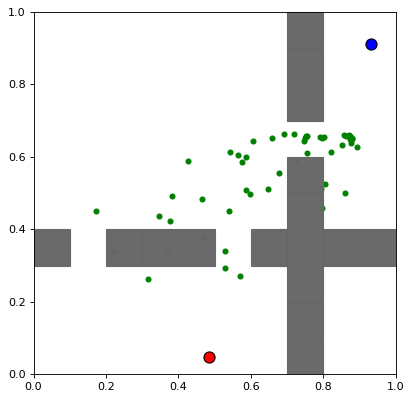

In [45]:
#Show the 10x10 figure formed after application of kernel
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')
for i in range(10):
        for j in range(10):
            if(new_occ_g[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/10.0, j/10.0),   # (x,y)
                0.1,          # width
                0.1,          # height
                alpha=6,
                color = "#676767"
                ))

plt.scatter(b_nodes[:,0],b_nodes[:,1], color="green", s=20)

plt.scatter(start[0], start[1], color = "red",  s = 100, edgecolors="black")
plt.scatter(goal[0], goal[1], color = "blue",  s = 100, edgecolors="black")
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

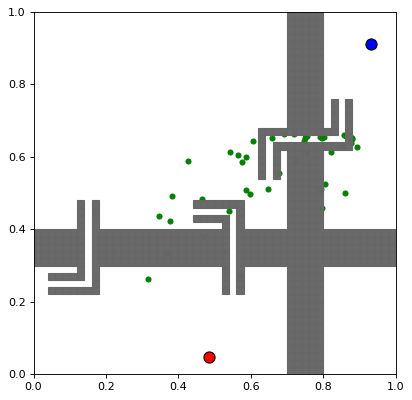

In [46]:
#Show the 50x50 figure 
fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')
for i in range(50):
        for j in range(50):
            if(occ_g_50[i,j]==0):
                ax1.add_patch(patches.Rectangle(
                (i/50.0, j/50.0),   # (x,y)
                1/50.0,          # width
                1/50.0,          # height
                alpha=6,
                color = "#676767"
                ))
plt.scatter(b_nodes[:,0],b_nodes[:,1], color="green", s=20)

plt.scatter(start[0], start[1], color = "red",  s = 100, edgecolors="black")
plt.scatter(goal[0], goal[1], color = "blue",  s = 100, edgecolors="black")
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

Tree  3  connected to  2
Tree  4  connected to  2
Tree  1  connected to  2
Tree  0  connected to  2
Path exists!!
Number of iterations: 959
found path!!


<Figure size 432x288 with 0 Axes>

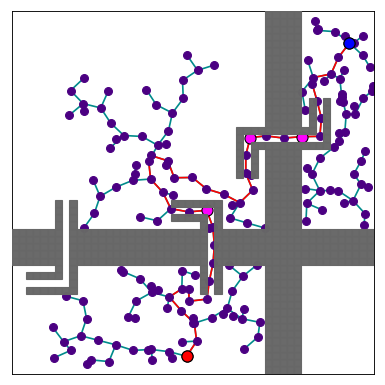

In [62]:
#Run CS-RRT
planner = CS_RRT(start=[start[0], start[1]],goal=[goal[0], goal[1]],expand_dis=0.05,occ_grid=occ_g_50,rand_area=[0, 1],b_nodes = b_nodes, graph_file="../Sparse_Graph/sparse_graph.graphml",max_iter=10000)
start_time = time.time()
path, dis = planner.planning(animation=True)
end_time = time.time()
if dis is None:
    print("Cannot find path")
    planner.draw_path([])
else:
    print("found path!!")
    planner.draw_path(path)